# Forecasting Water Levels using LSTMs

In [17]:
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from wetterdienst.provider.dwd.observation import DwdObservationRequest, \
    DwdObservationPeriod, DwdObservationResolution, DwdObservationParameter, DwdObservationDataset

In [18]:
df = pd.read_csv('data/Kaub_Level_Since_2013.csv')
x = df[df.duplicated(['date'])].index
x

Int64Index([2521, 2535], dtype='int64')

In [19]:
df_index = df.set_index(df['date'])
df_index.index = pd.to_datetime(df_index.index)
dates_original = pd.date_range(start=df['date'].iloc[0], end=df['date'].iloc[-1]).difference(df_index.index)
print('These are the missing dates on the updated data: \n', dates_original)
print(f'There are a total of {len(dates_original)} dates missing.')

These are the missing dates on the updated data: 
 DatetimeIndex([], dtype='datetime64[ns]', freq=None)
There are a total of 0 dates missing.


In [27]:
for element in x:
    df.drop(element, inplace=True)

In [28]:
df = df.reset_index(drop=True)

In [29]:
path = 'results/' # Path for saving the figures later on

In [38]:
def get_station_id(city):
    request = DwdObservationRequest(
        parameter=DwdObservationDataset.PRECIPITATION_MORE,
        resolution=DwdObservationResolution.DAILY,
        period=DwdObservationPeriod.HISTORICAL
    )
    df_lu = request.all().df
    station_string = df_lu[df_lu['name'] == city].station_id
    print(station_string)
    return int(station_string.iloc[0][1:])


There is no Ludwigshafen in the DWD weather API, so I use Mannheim instead.

In [39]:
ma_id = get_station_id('Mannheim')
frei_id = get_station_id('Freiburg')

5276    05906
Name: station_id, dtype: object


5906

In [25]:
request = DwdObservationRequest(
    parameter=DwdObservationDataset.PRECIPITATION_MORE,
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
)
df_lu = request.all().df
df_lu[df_lu['name'] == 'Ludwigshafen']

,station_id,from_date,to_date,height,latitude,longitude,name,state


In [26]:
station_id = df_lu[df_lu['name'] == 'Mannheim'].station_id
station_id

5276    05906
Name: station_id, dtype: object

## What variables have an impact on water levels? https://ijc.org/en/lsbc/watershed/faq/3

Get data from DWD

200km: From Freiburg to Ludwigshafen. Rhine has a speed of 10 kph on average => Shift of 20h / approximately 1 day

In [403]:
station_id = df_lu[df_lu['name'] == 'Freiburg'].station_id
station_id

1272    01443
Name: station_id, dtype: object

In [ ]:
request = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
).filter_by_station_id(station_id=(1443, ))

precipitation_frei_historical = request.values.all().df
precipitation_frei_historical

In [ ]:
request = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.RECENT
).filter_by_station_id(station_id=(1443, ))

precipitation_frei_recent = request.values.all().df

precipitation_frei_recent

In [335]:
request = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
).filter_by_station_id(station_id=(5906, ))

precipitation_ma_historical = request.values.all().df
precipitation_ma_historical

,station_id,dataset,parameter,date,value,quality
0,05906,climate_summary,precipitation_height,1936-01-01 00:00:00+00:00,0.3,5.0
1,05906,climate_summary,precipitation_height,1936-01-02 00:00:00+00:00,2.4,5.0
2,05906,climate_summary,precipitation_height,1936-01-03 00:00:00+00:00,8.8,5.0
3,05906,climate_summary,precipitation_height,1936-01-04 00:00:00+00:00,0.0,5.0
4,05906,climate_summary,precipitation_height,1936-01-05 00:00:00+00:00,0.0,5.0
...,...,...,...,...,...,...
28120,05906,climate_summary,precipitation_height,2020-12-27 00:00:00+00:00,4.5,3.0
28121,05906,climate_summary,precipitation_height,2020-12-28 00:00:00+00:00,5.2,3.0
28122,05906,climate_summary,precipitation_height,2020-12-29 00:00:00+00:00,0.0,3.0
28123,05906,climate_summary,precipitation_height,2020-12-30 00:00:00+00:00,2.2,3.0


request = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT,
        DwdObservationParameter.DAILY.PRESSURE_AIR_SITE,
        DwdObservationParameter.DAILY.TEMPERATURE_AIR_MEAN_200,
        DwdObservationParameter.DAILY.WIND_SPEED
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.HISTORICAL
).filter_by_station_id(station_id=(5906, ))

station_data = request.values.all().df
station_data

In [336]:
precipitation_data_mannheim_recent = DwdObservationRequest(
    parameter=[
        DwdObservationParameter.DAILY.PRECIPITATION_HEIGHT
    ],
    resolution=DwdObservationResolution.DAILY,
    period=DwdObservationPeriod.RECENT
).filter_by_station_id(station_id=(5906, ))

precipitation_ma_recent = precipitation_data_mannheim_recent.values.all().df

precipitation_ma_recent

,station_id,dataset,parameter,date,value,quality
0,05906,climate_summary,precipitation_height,2020-06-06 00:00:00+00:00,1.0,3.0
1,05906,climate_summary,precipitation_height,2020-06-07 00:00:00+00:00,0.0,3.0
2,05906,climate_summary,precipitation_height,2020-06-08 00:00:00+00:00,0.0,3.0
3,05906,climate_summary,precipitation_height,2020-06-09 00:00:00+00:00,0.0,3.0
4,05906,climate_summary,precipitation_height,2020-06-10 00:00:00+00:00,0.0,3.0
...,...,...,...,...,...,...
545,05906,climate_summary,precipitation_height,2021-12-03 00:00:00+00:00,6.9,1.0
546,05906,climate_summary,precipitation_height,2021-12-04 00:00:00+00:00,8.7,1.0
547,05906,climate_summary,precipitation_height,2021-12-05 00:00:00+00:00,0.0,1.0
548,05906,climate_summary,precipitation_height,2021-12-06 00:00:00+00:00,0.3,1.0


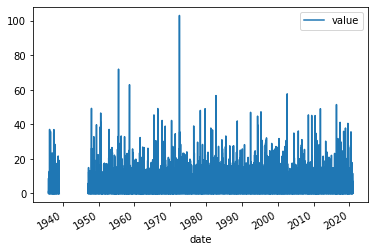

In [337]:
precipitation_ma_historical.plot(x="date", y="value")
plt.show()

28125 550


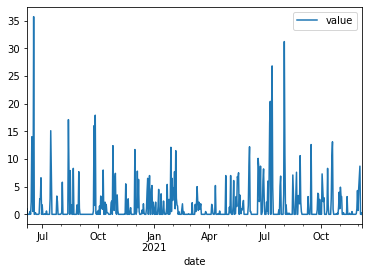

In [338]:
precipitation_ma_recent.plot(x='date', y='value')
print(len(precipitation_ma_historical), len(precipitation_ma_recent))

In [339]:
#date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d')
#timestamp_s = date_time.map(pd.Timestamp.timestamp)

In [340]:
precipitation_ma_historical['date'] = pd.to_datetime(precipitation_ma_historical['date'], unit='s').dt.date
precipitation_ma_recent['date'] = pd.to_datetime(precipitation_ma_recent['date'], unit='s').dt.date

In [341]:
startdate = pd.to_datetime("2013-01-01").date()
enddate = pd.to_datetime("2020-12-31").date()
precipitation_ma_historical = precipitation_ma_historical.loc[precipitation_ma_historical['date'].between(startdate, enddate, inclusive=True)]

/tmp/ipykernel_126814/1158039309.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  precipitation_ma_historical = precipitation_ma_historical.loc[precipitation_ma_historical['date'].between(startdate, enddate, inclusive=True)]


In [342]:
precipitation_ma_historical

,station_id,dataset,parameter,date,value,quality
25203,05906,climate_summary,precipitation_height,2013-01-01,0.6,9.0
25204,05906,climate_summary,precipitation_height,2013-01-02,0.0,9.0
25205,05906,climate_summary,precipitation_height,2013-01-03,1.8,9.0
25206,05906,climate_summary,precipitation_height,2013-01-04,0.3,9.0
25207,05906,climate_summary,precipitation_height,2013-01-05,0.0,9.0
...,...,...,...,...,...,...
28120,05906,climate_summary,precipitation_height,2020-12-27,4.5,3.0
28121,05906,climate_summary,precipitation_height,2020-12-28,5.2,3.0
28122,05906,climate_summary,precipitation_height,2020-12-29,0.0,3.0
28123,05906,climate_summary,precipitation_height,2020-12-30,2.2,3.0


In [343]:
startdate = pd.to_datetime("2021-1-1").date()
enddate = pd.to_datetime("2021-10-27").date()
station_data_recent = precipitation_ma_recent.loc[precipitation_ma_recent['date'].between(startdate, enddate, inclusive=True)]

/tmp/ipykernel_126814/3555343357.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  station_data_recent = precipitation_ma_recent.loc[precipitation_ma_recent['date'].between(startdate, enddate, inclusive=True)]


In [344]:
df1 = precipitation_ma_historical[precipitation_ma_historical.isna().any(axis=1)]
df1

,station_id,dataset,parameter,date,value,quality
27122,05906,climate_summary,precipitation_height,2018-04-04,NaN,NaN
27123,05906,climate_summary,precipitation_height,2018-04-05,NaN,NaN


In [345]:
df1 = station_data_recent[station_data_recent.isna().any(axis=1)]
df1

,station_id,dataset,parameter,date,value,quality


In [346]:
precipitation_ma_historical = precipitation_ma_historical.fillna(method='ffill')

In [347]:
#assert(len(station_data) + len(station_data_recent) == len(df))

In [348]:
precipitation_ma_historical = precipitation_ma_historical.append(station_data_recent).reset_index(drop=True)

In [349]:
precipitation_ma_historical = precipitation_ma_historical.rename({'value':'precipitation_height'}, axis=1)
precipitation_ma_historical = precipitation_ma_historical.drop(['parameter', 'dataset', 'station_id', 'quality'], axis=1)

In [350]:
assert(len(precipitation_ma_historical) == len(df))

Delete strong outliers with the help of the zscore.

In [351]:
df = df.drop('date', axis = 1)

In [352]:
precipitation_ma_historical = precipitation_ma_historical.drop('date', axis = 1)


In [353]:
precipitation_ma_historical

,precipitation_height
0,0.6
1,0.0
2,1.8
3,0.3
4,0.0
...,...
3217,0.0
3218,0.0
3219,0.0
3220,0.1


In [354]:
df

,level
0,510
1,461
2,414
3,378
4,351
...,...
3217,117
3218,105
3219,93
3220,85


In [355]:
df['precipitation_height'] = precipitation_ma_historical['precipitation_height']

In [356]:
df['precipitation_height'].corr(df['level'])


0.051382945005641625

In [357]:
df.head(21)

,level,precipitation_height
0,510,0.6
1,461,0.0
2,414,1.8
3,378,0.3
4,351,0.0
5,330,0.1
6,323,0.0
7,322,0.0
8,311,0.7
9,296,0.0


Split the data in train-validation-test split: 70:20:10 ratio. In order to get a more accurate overall presentation of the data, i.e. to guarantee that the data is i.i.d, one could randomly shuffle the data. This generally leads to lower variance and less overfitting when training a neural network. I did not decide to do this however, since this would influence the performance of the model because the data points are time dependent on each other.

In [358]:
column_indices = {name: i for i, name in enumerate(df.columns)}
train_df = df[0:int(len(df)*0.7)]
val_df = df[int(len(df)*0.7):int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]

num_features = df.shape[1]

In [359]:
train_df.describe()

,level,precipitation_height
count,2255.000000,2255.000000
mean,205.968071,1.696763
std,103.875257,4.090127
min,20.000000,0.000000
25%,137.000000,0.000000
50%,192.000000,0.000000
75%,256.000000,1.500000
max,713.000000,51.500000


In [360]:
test_df.describe()

,level,precipitation_height
count,323.000000,323.000000
mean,241.931889,1.786068
std,122.185158,3.779040
min,82.000000,0.000000
25%,152.000000,0.000000
50%,217.000000,0.000000
75%,301.500000,1.950000
max,663.000000,31.200000


In [361]:
print(f'Train mean: {train_df["level"].mean()}, Train std: {train_df["level"].std()}')

Train mean: 205.9680709534368, Train std: 103.87525729300474


In [362]:
print(f'Validation mean: {val_df["level"].mean()}, {val_df["level"].std()}')

Validation mean: 190.75776397515529, 79.95479098932333


In [363]:
print(f'Test mean: {test_df["level"].mean()}, {test_df["level"].std()}')

Test mean: 241.93188854489165, 122.18515759995832


As could be seen in the notebook 'analysis', there is a trend in the data. While there exists an overall downward trend in the water levels of the rhine, as can be seen via linear regression, the overall mean level in the last 10% of the time series actually rose significantly. This is also due to the higher standard deviation, i.e. the water levels have higher highs and lower lows.

Test, if split was successful.

In [364]:
assert(len(train_df) + len(val_df) + len(test_df) == len(df))

Maybe use moving averages instead of average in the next cell since the model shouldn't have access to future values in the training set when training?!

In [365]:
pre_transformation = train_df

Since there are many outliers, we use the RobustScaler instead of the StandardScaler.

In [366]:
scaler = RobustScaler().fit(train_df.values)
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/pascal/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


In [367]:
train_df = pd.DataFrame(train_scaled, index=train_df.index, columns=train_df.columns)
val_df = pd.DataFrame(val_scaled, index=val_df.index, columns=val_df.columns)
test_df = pd.DataFrame(test_scaled, index=test_df.index, columns=test_df.columns)

In [368]:
train_df

,level,precipitation_height
0,2.672269,0.400000
1,2.260504,0.000000
2,1.865546,1.200000
3,1.563025,0.200000
4,1.336134,0.000000
...,...,...
2250,-0.428571,0.866667
2251,-0.403361,0.000000
2252,-0.235294,0.000000
2253,-0.067227,1.533333


In [369]:
pre_transformation

,level,precipitation_height
0,510,0.6
1,461,0.0
2,414,1.8
3,378,0.3
4,351,0.0
...,...,...
2250,141,1.3
2251,144,0.0
2252,164,0.0
2253,184,2.3


<AxesSubplot:>

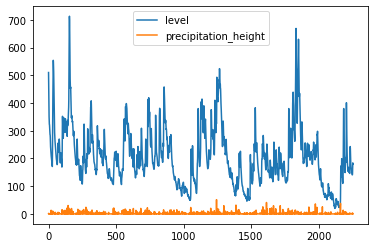

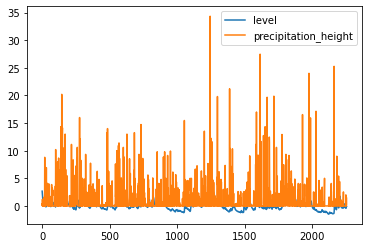

In [370]:
pre_transformation.plot()
train_df.plot()

In [371]:
print(f' The data pre transformation is in range [{pre_transformation["level"].min()},  {pre_transformation["level"].max()}]\n'
      f' the data after transformation is in range: [{round(test_df["level"].min(),2)}, {round(test_df["level"].max(), 2)}]')
      

 The data pre transformation is in range [20,  713]
 the data after transformation is in range: [-0.92, 3.96]


In [372]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [373]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [374]:
def plot(self, model=None, plot_col='level', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
    
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Day')

WindowGenerator.plot = plot


In [375]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [376]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [377]:
single_step_window = WindowGenerator(
    input_width=30, label_width=30, shift=7,
    label_columns=['level'])
single_step_window

single_step_window


Total window size: 37
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36]
Label column name(s): ['level']

In [378]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    

Inputs shape (batch, time, features): (32, 30, 2)
Labels shape (batch, time, features): (32, 30, 1)


In [379]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


In [380]:
baseline = Baseline(label_index=column_indices['level'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


19/19 [==============================] - 0s 546us/step - loss: 0.3073 - mean_absolute_error: 0.3928


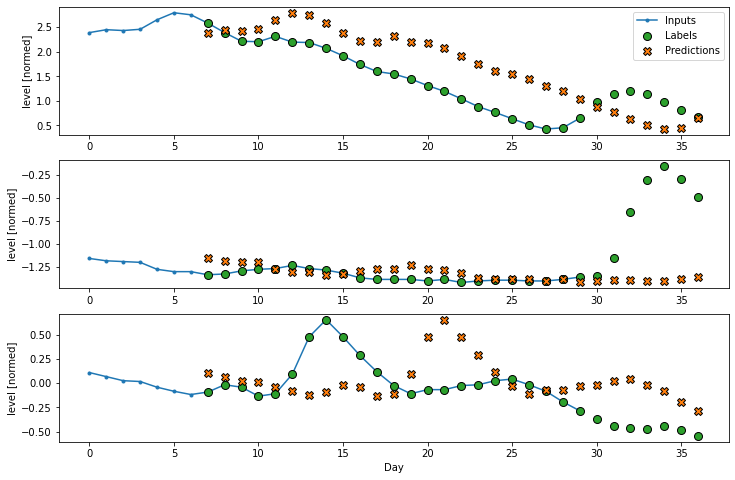

In [381]:
single_step_window.plot(baseline)


In [382]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

Using Huber Loss for more robustness against outliers (vs for example mean squared error)

In [383]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(6, return_sequences=True),
    tf.keras.layers.LSTM(4, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])


In [384]:
history = compile_and_fit(lstm_model, single_step_window)
train_performance = {}
IPython.display.clear_output()
train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0)



19/19 [==============================] - 0s 3ms/step - loss: 0.1058 - mean_absolute_error: 0.3608


In [385]:
lstm_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 6)             216       
                                                                 
 lstm_7 (LSTM)               (None, 30, 4)             176       
                                                                 
 dense_12 (Dense)            (None, 30, 1)             5         
                                                                 
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


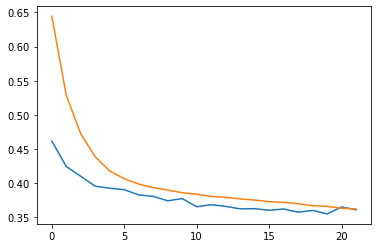

In [386]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

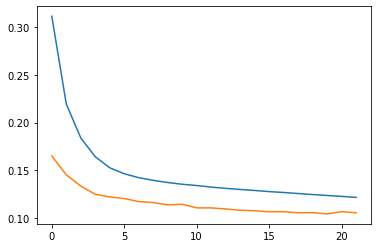

In [387]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

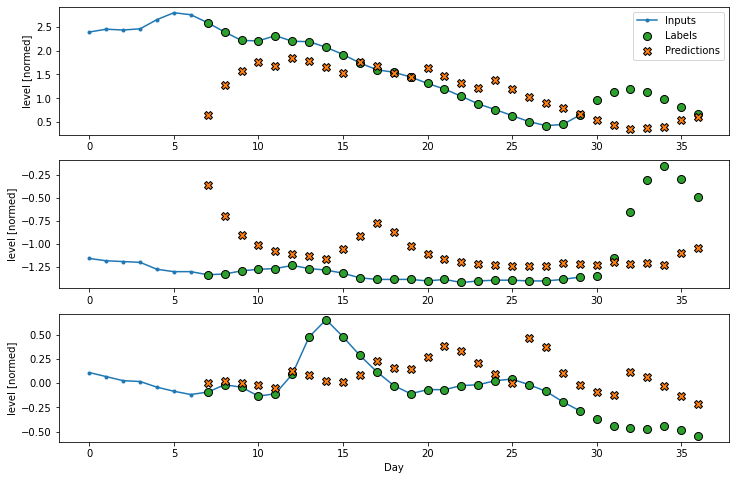

In [388]:
single_step_window.plot(lstm_model)

In [389]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name:12s}: {value[1]:0.4f}')


Test Mean absolute Error Baseline    : 0.5155
Test Mean absolute Error LSTM        : 0.4596


StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

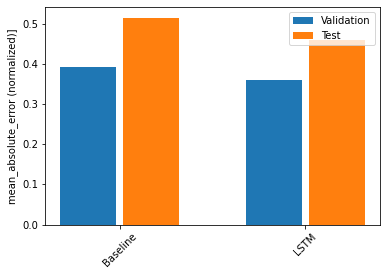

In [390]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


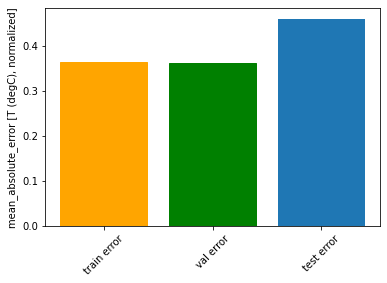

In [391]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
LSTM_performance = [train_performance['LSTM'][1], val_performance['LSTM'][1], performance['LSTM'][1]]
barlist = plt.bar(x, LSTM_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')

plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
predictions = model(inputs)
plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

In [392]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


In [393]:
ffn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(6),
    tf.keras.layers.Dense(4),
    tf.keras.layers.Dense(units=1)
])


In [394]:
history = compile_and_fit(ffn_model, single_step_window)
train_performance = {}
IPython.display.clear_output()
train_performance['Dense'] = ffn_model.evaluate(single_step_window.train)
val_performance['Dense'] = ffn_model.evaluate(single_step_window.val)
performance['Dense'] = ffn_model.evaluate(single_step_window.test, verbose=0)



19/19 [==============================] - 0s 727us/step - loss: 0.1071 - mean_absolute_error: 0.3535


In [395]:
ffn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 30, 6)             18        
                                                                 
 dense_14 (Dense)            (None, 30, 4)             28        
                                                                 
 dense_15 (Dense)            (None, 30, 1)             5         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [396]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


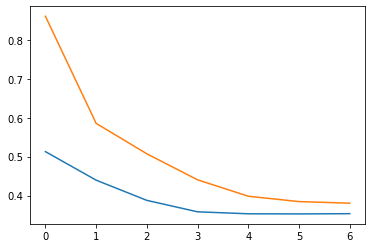

In [397]:
plt.plot(history.history['val_mean_absolute_error'])
plt.plot(history.history['mean_absolute_error'])

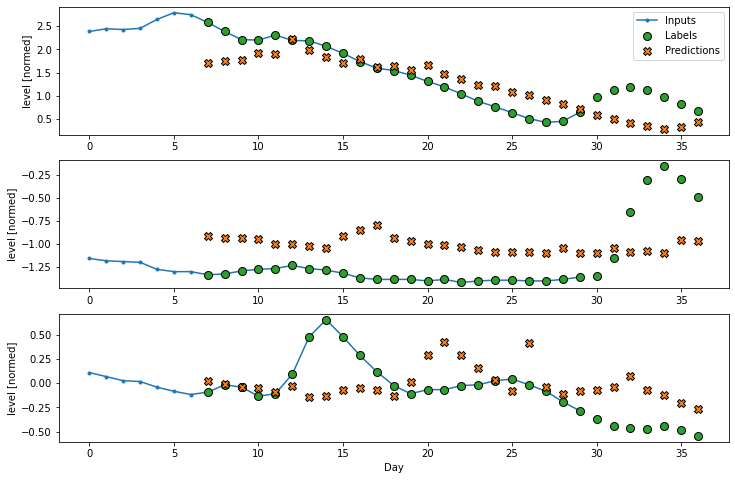

In [398]:
single_step_window.plot(ffn_model)

In [399]:
for name, value in performance.items():
    print(f'Test Mean absolute Error {name:12s}: {value[1]:0.4f}')


Test Mean absolute Error Baseline    : 0.5155
Test Mean absolute Error LSTM        : 0.4596
Test Mean absolute Error Dense       : 0.4441


StandardScaler:
Baseline test: 0.1192
LSTM test: 0.0842

RobustScaler:
Baseline test    : 0.1040
LSTM test     : 0.0708

PowerTransformer:
Baseline test: 0.1016
LSTM test: 0.0721

When deleting the data with zscore < 3 and RobustScaler:
Baseline test   : 0.0960
LSTM test        : 0.0675


Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.4026

with 30 index, 30 label, 7 shift:


Feed forward network: 16, 4 layers: 

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3795



LSTM: 6,4 layers:

Test Mean absolute Error Baseline    : 0.4157
Test Mean absolute Error LSTM        : 0.3875

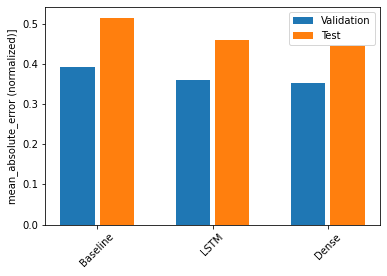

In [400]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error (normalized)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


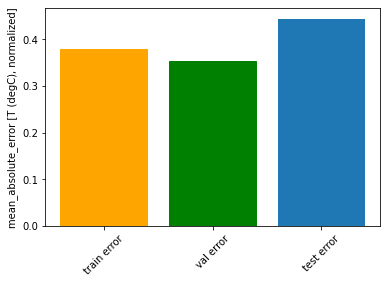

In [401]:
plt.ylabel('mean_absolute_error [T (degC), normalized]')
x = np.arange(3)
dense_performance = [train_performance['Dense'][1], val_performance['Dense'][1], performance['Dense'][1]]
barlist = plt.bar(x, dense_performance)
plt.xticks(ticks=x, labels=['train error', 'val error', 'test error'],
           rotation=45)
barlist[0].set_color('orange')
barlist[1].set_color('g')